# Лабораторная работа #1 по курсу "Методы оптимизации"
### Выполнил: Косенков Александр - студент группы РК6-64Б

## Задание:
Предложить функцию одной переменной $y=f(x)$, наиболее точно аппроксимирующую заданную выборку ${(x_i, y_i)_{i=1}^N}$.\
Найти значения параметров функции $f(x)$, которые минимизируют среднеквадратичную ошибку аппроксимации данных.

**Импорт всех необходимых библиотек:**

In [7]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pathlib
from scipy.optimize import curve_fit

**Определение конфигурационных переменных**

In [8]:
ROOT_DIR = str(pathlib.Path().absolute())
PLOTS_DPI = 300

**Определение всех необходимых функций**

In [9]:
# Функция построения графика функции-аппроксиматора в сравнении с исходными данными
def show_approximate(opt_func, params, x_plot, y_plot):
    plot_nodes_amount = 200
    l_limit = x_plot[0]
    r_limit = x_plot[-1]
    
    opt_plot = np.linspace(l_limit, r_limit, plot_nodes_amount)
    y_func = np.array([opt_func(x, *params) for x in opt_plot])
    
    _, axes = plt.subplots(1, 1, figsize=(16, 9), dpi=PLOTS_DPI)
    
    axes.scatter(x_plot, y_plot, s=6, color='blue', label='Исходные данные')
    axes.plot(x_plot, y_plot, color='green', label='Кусочно-линейная интерполяция')
    axes.plot(opt_plot, y_func, color='red', label='Аппроксимирующая функция')
    
    plt.xlabel('x')
    plt.ylabel('y')
    
    axes.legend(loc='best')
    axes.grid()
    
    plt.show()
    opt_data = np.array([opt_func(x, *params) for x in x_plot])
    max_err, rmse = calculate_deviations(y_plot, opt_data)
    print("Максимальное отклонение = {}\nСреднеквадратичная ошибка = {}".format(max_err, rmse))

# Функция подсчета среднекваратичной ошибки и максимального отклонения
def calculate_deviations(initial_data, approximate_data):
    max_error = np.max(np.abs(initial_data - approximate_data))
    rmse = np.sqrt(np.sum(np.power(initial_data - approximate_data, 2)) / len(initial_data))
    return max_error, rmse

**Генерация и сортировка numpy-массива по данным из файла `lab1.csv`**

In [10]:
csv_data = np.genfromtxt(ROOT_DIR + '/lab1.csv', delimiter=' ')
csv_data = csv_data[csv_data[:,0].argsort()]

Построение графика кусочно-линейной интерполяции по значениям, полученным из файла

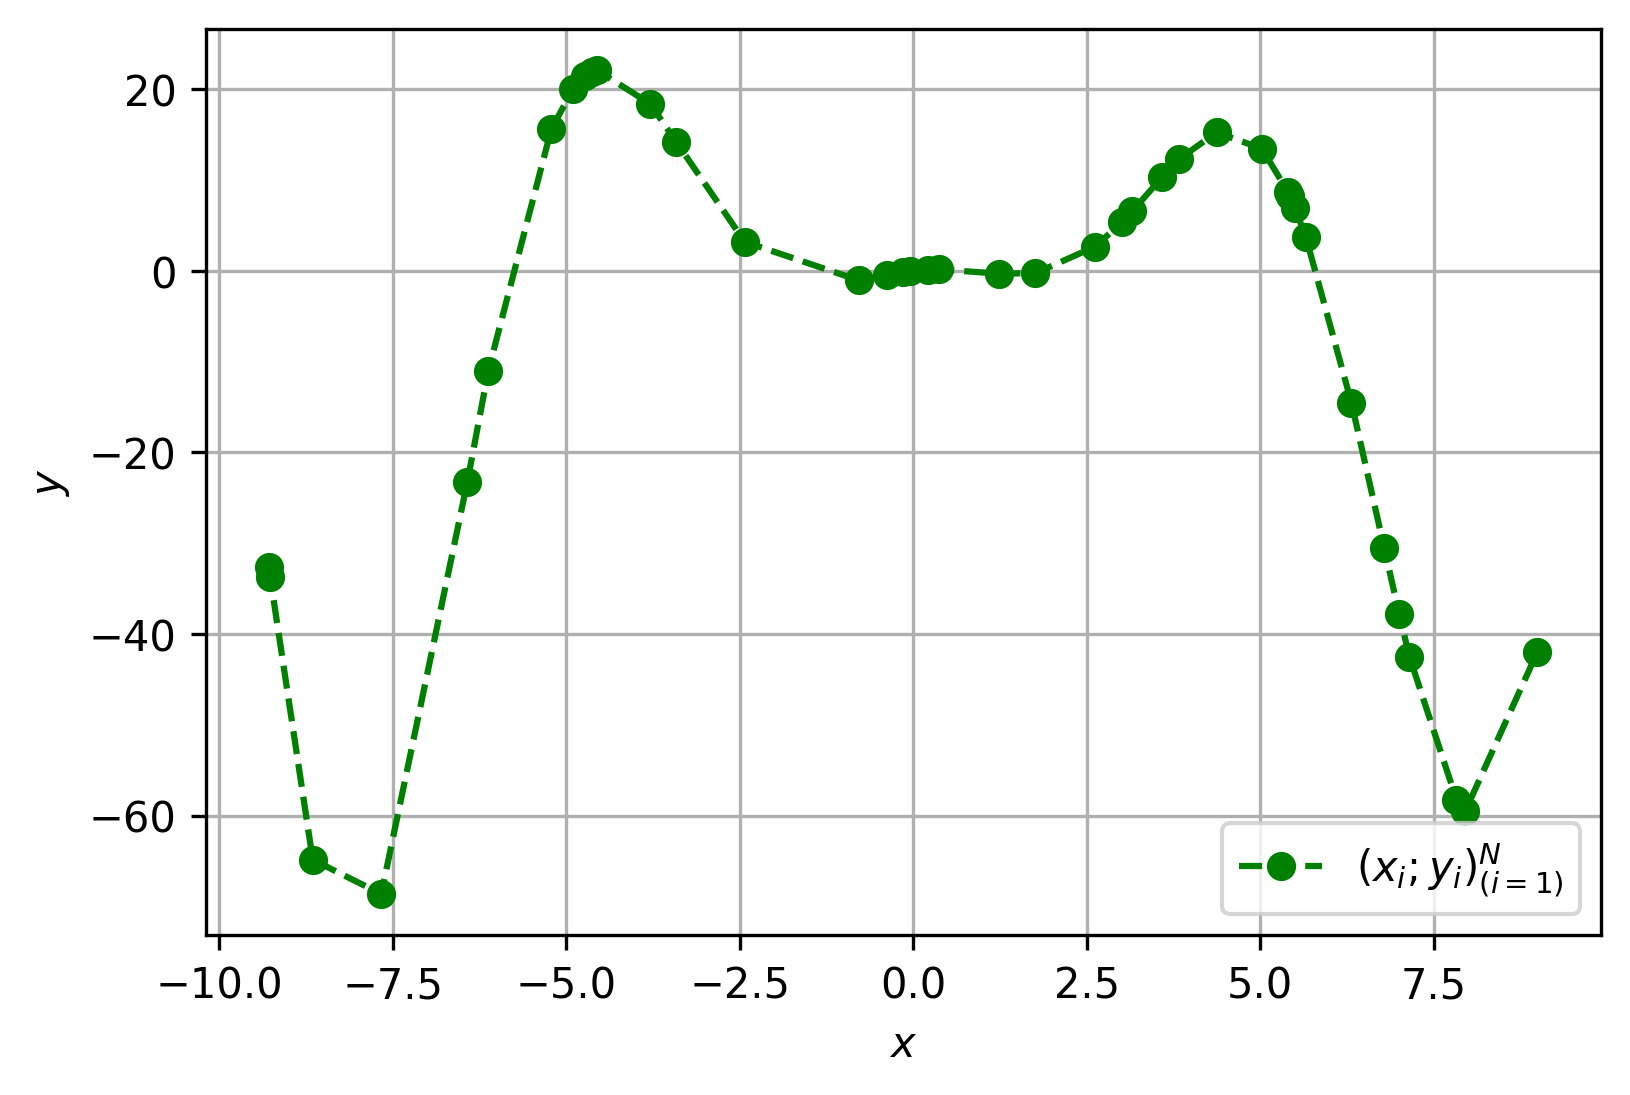

In [11]:
x_plot = [pair[0] for pair in csv_data]
y_plot = [pair[1] for pair in csv_data]

fig, axes = plt.subplots(nrows=1, ncols=1, dpi=PLOTS_DPI)
axes.plot(x_plot, y_plot, color="green", linestyle="dashed", marker="o", label=r'$(x_i;y_i)_{(i=1)}^N$')
axes.set_xlabel(r'$x$')
axes.set_ylabel(r'$y$')
axes.legend(loc='best')
axes.grid()
plt.show()

Для получения функции-аппроксиматора, необходимо проанализировать полученную кусочно-линейную интерполяцию и выявить
определенные характеристики функции, такие как четность/нечетность, периодичность, ассимптотичность, а также определить
ряд ключевых точек, таких как экстремумы. Выявление данных характеристик и ключевых точек необходимо для определения
**базисных функций**, сочетаниями которых и будет задаваться главная функция-аппроксиматор.\
Анализируя график исходных данных можно выявить следующие характеритсики зависимости:
    - четность графика относительно x = 0
    - периодичность на интервале [-6; 0] и симметричном ему [0; 6]
Также выделяются экстремумы графика около точек x = 7.5 и -7.5
    
Сочетая обе характеристики, можно сделать вывод, что одним из компонентов может являться косинус, т.к. он является
четной периодичной функцией. Причем промежуток [-6; 6] похож на поведение отрицательного косинуса. Итого - первый
компонент - **-cos(kx+p)**.\
Экстремумов около точек x = 7.5 и x = -7.5 можно достичь с помощью полинома четной степени, поскольку данные
экстремумы симметричны. Причем данный полином должен иметь отрицательный знак перед старшей степенью. Итого - 
второй компонент - **-ax^2 + bx + c**.\
Дальнейший анализ включает в себя сочетание этих компонентов. Можно заметить незначительную выпуклость вверх в
окрестности точки x = 0, а также экстремумы функции, рассмотренные ранее. Изменения значений первого базисного
компонента можно достичь перемножением этих двух компонентов. Данная идея и была реализована далее.

In [12]:
def first_func(x, a, b, c, k, p):
    return -np.cos(k*x + p)*((x ** 2) * a + b*x + c)

Для определения параметров **a, b, c, k, p** была решена задача оптимизации с помощью функции `scipy.optimize.curve_fit`,
которая находит значения параметров с помощью метода наименьших квадратов.

In [13]:
solution, _ = curve_fit(first_func, x_plot, y_plot)
print("Coefficients: a={}, b={}, с={}, k={}, p={}".format(*solution))

Coefficients: a=0.03269939720634649, b=-6.462601314693845, с=0.8925712186080407, k=0.9967760517784445, p=1.726103612330376


## Построение графика фукции-аппроксиматора с найденными оптимальными коэффициентами

In [14]:
show_approximate(opt_func=first_func, params=solution, x_plot=x_plot, y_plot=y_plot)

Максимальное отклонение = 25.715596068275506
Среднеквадратичная ошибка = 11.991807559407665


Из результатирующего графика видно большое расхождение с изначальной интерполяцией, что обусловлено большим количеством
параметров и отсутствием ограничений на них. Исходя из уже полученных значений коэффициентов - устанавливаются ограничения
на параметры (произвольным образом, учитывая полученные на предыдущем этапе значения), при этом также был занулен сдвиг
косинуса по фазе с целью исследования дальнейшего поведения функции.

## 2-я итерация - ввод ограничений

Coefficients: a=1.0599999999893595, b=-0.8499999998944995, с=-2.923804175846227e-11, k=0.810000000003013, p=6.492154281856448e-11


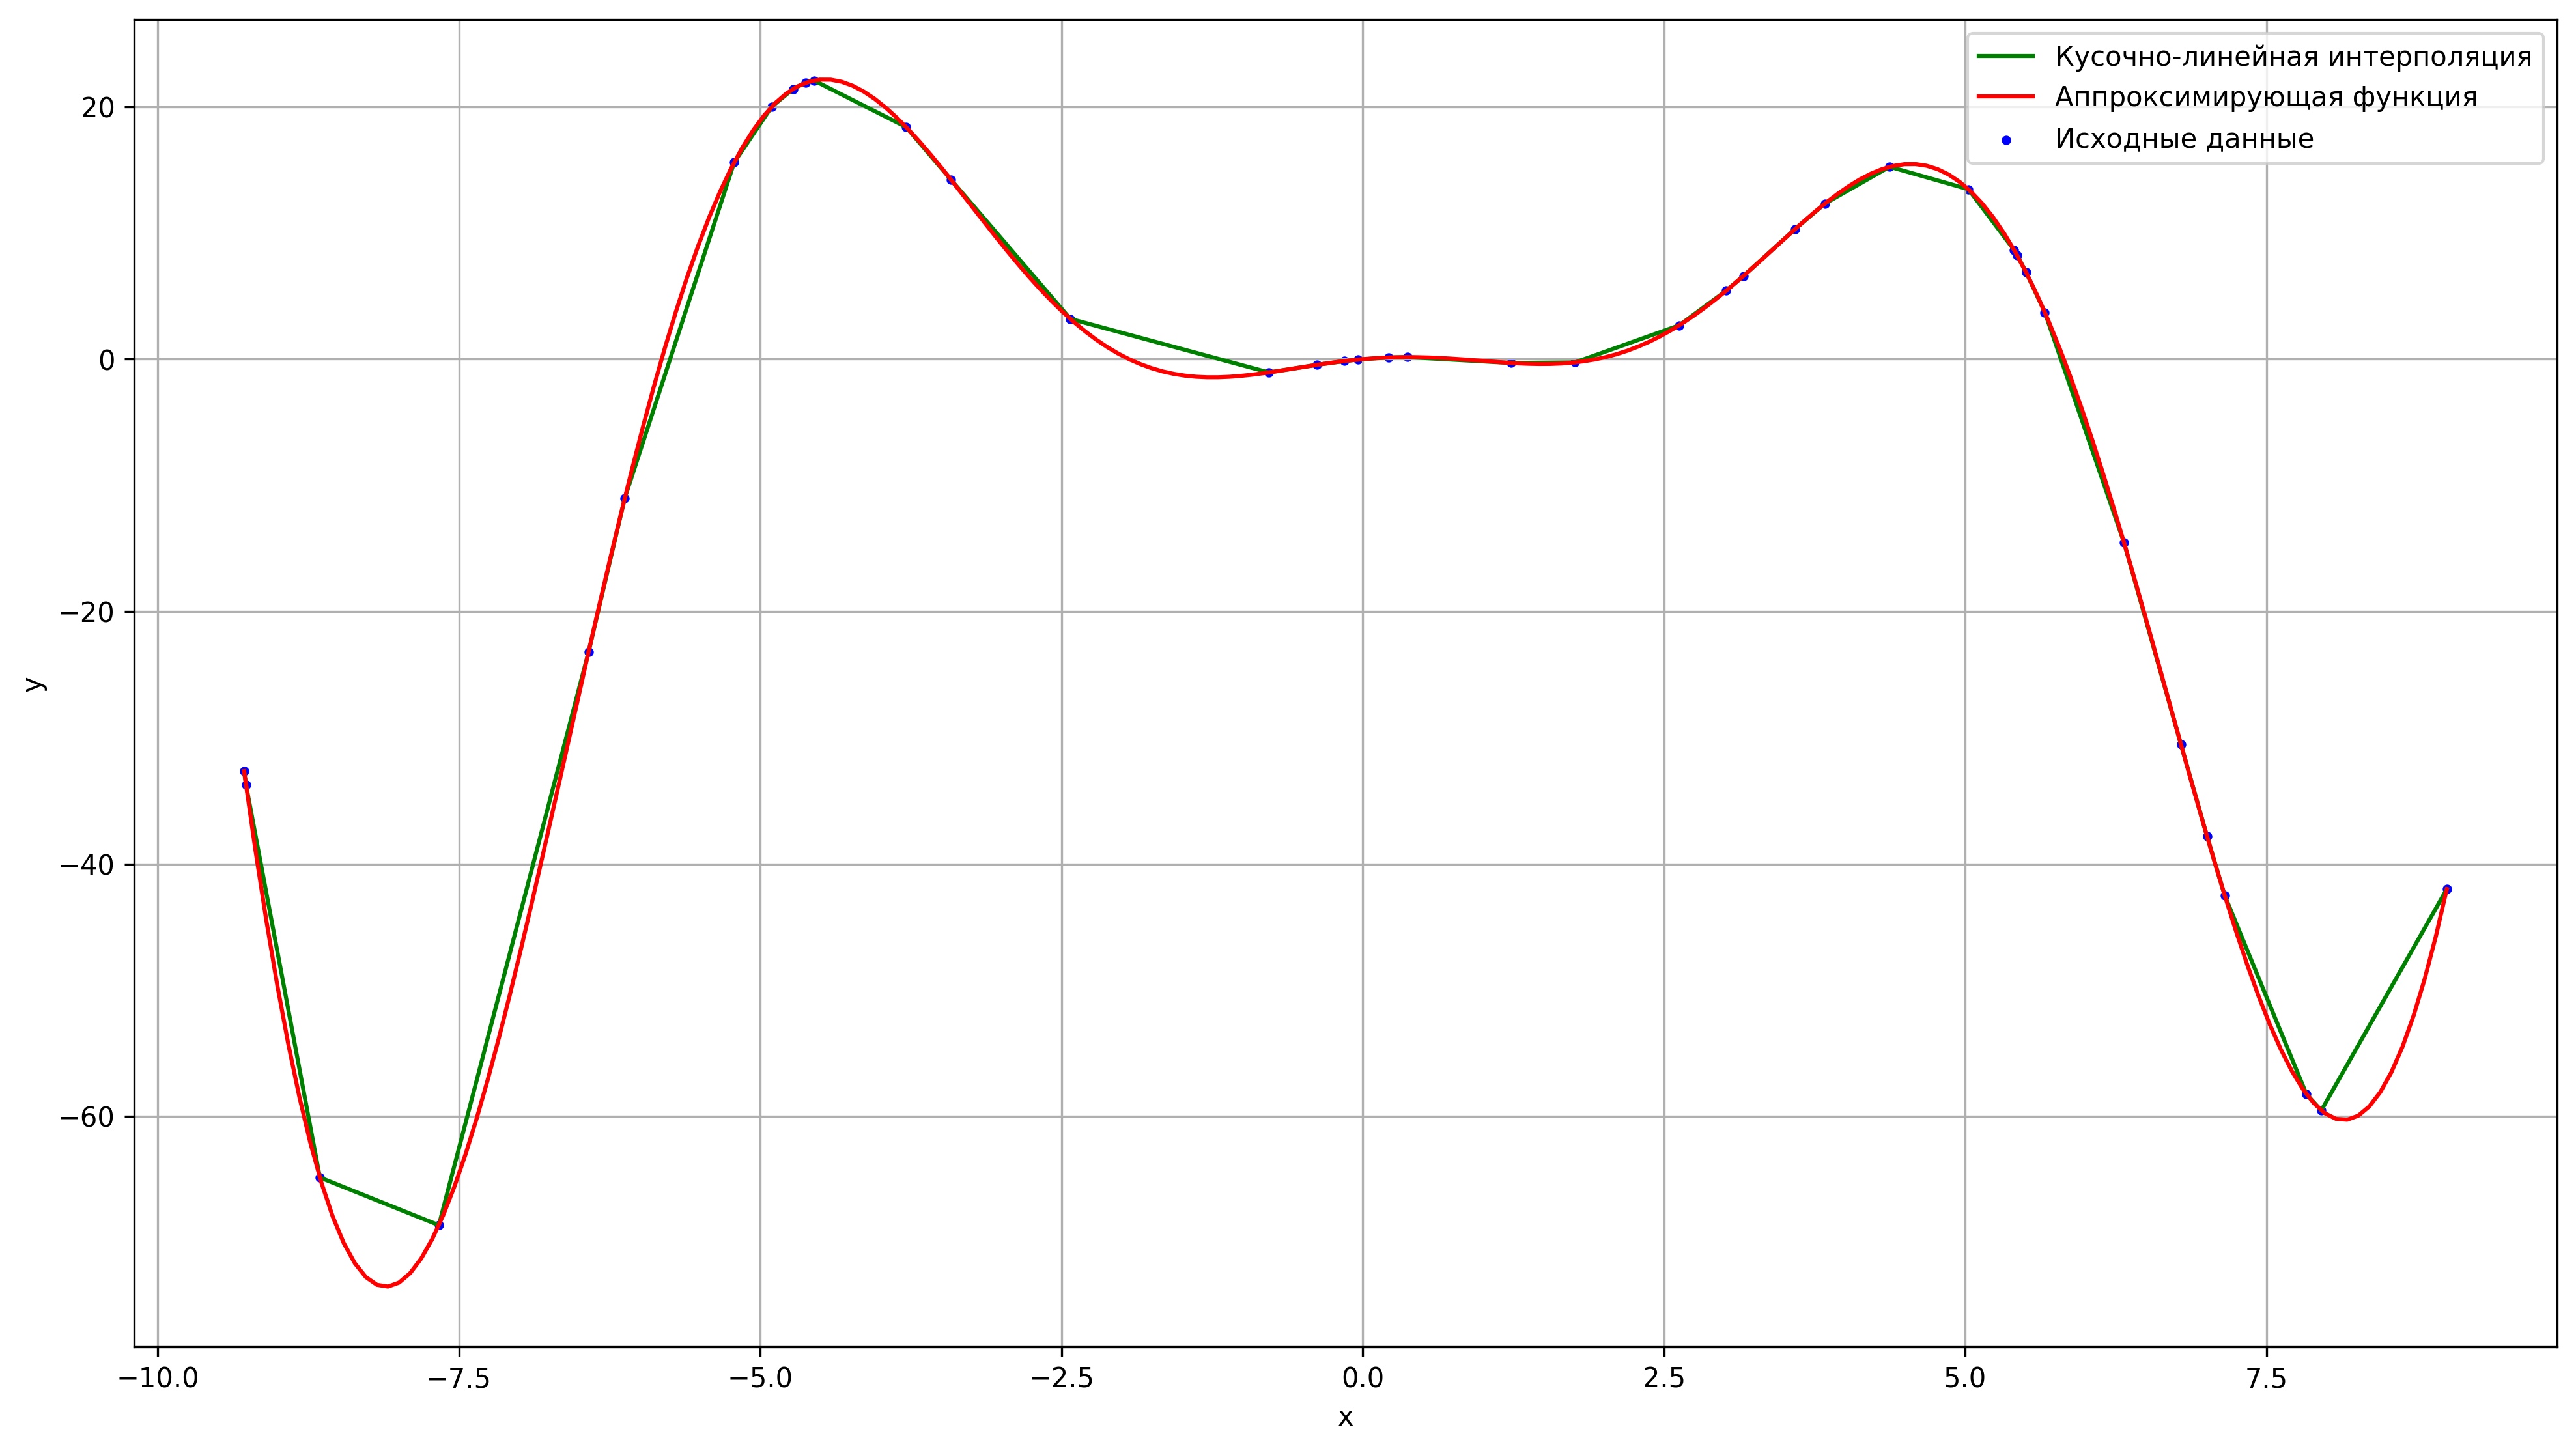

Максимальное отклонение = 6.030951738011936e-09
Среднеквадратичная ошибка = 1.7142577437584931e-09


In [15]:
solution, _ = curve_fit(first_func, x_plot, y_plot, bounds=([0, -10, -1, 0, 0], [2, 0, 3, 2, 1e-10]))
print("Coefficients: a={}, b={}, с={}, k={}, p={}".format(*solution))
show_approximate(opt_func=first_func, params=solution, x_plot=x_plot, y_plot=y_plot)

Как можно заметить из графика - исключение сдвига по фазе положительно повлияло на аппроксимацию, приблизив функцию к
исходным данным и синтерполировав гладкое поведение между точками. К тому же, значение параметра $`c`$ крайне мало, что
говорит о том, что этот параметр также можно редуцировать.

## 3-я итерация - конечный вариант

Coefficients: a=1.06, b=-0.8500000000000009, k=0.81


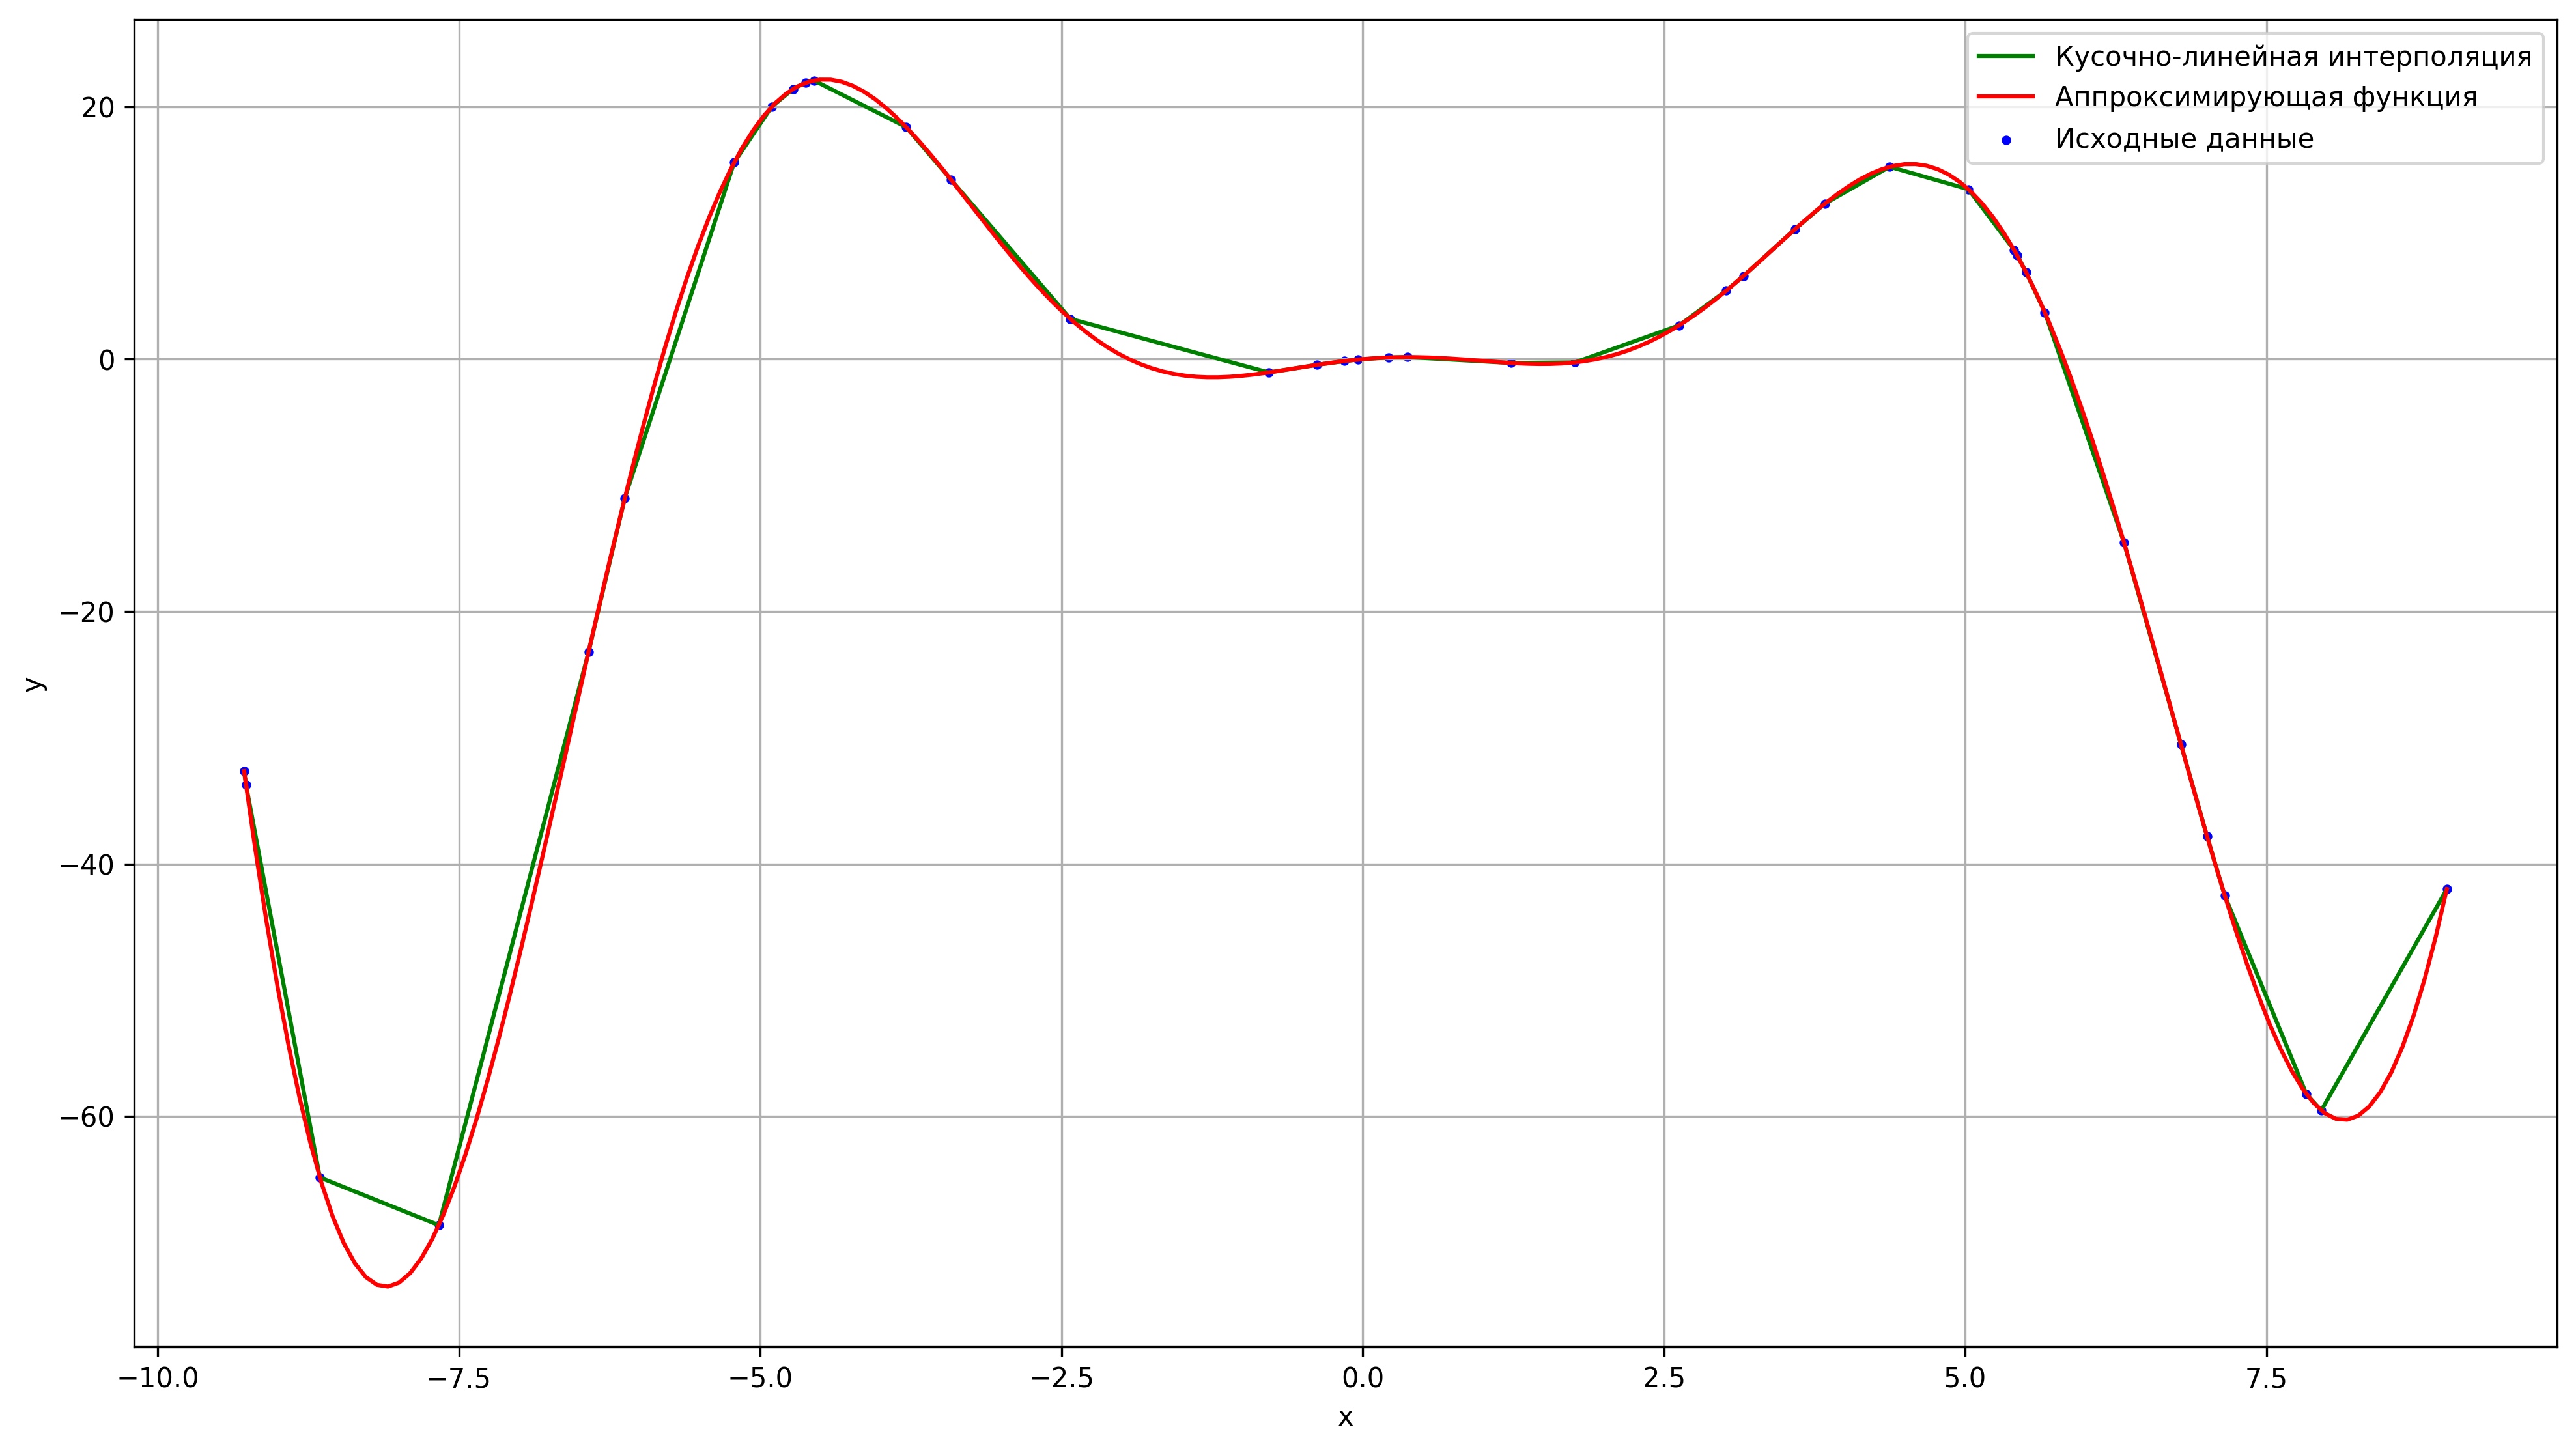

Максимальное отклонение = 1.4210854715202004e-14
Среднеквадратичная ошибка = 3.913827885898327e-15


In [16]:
def opt_func(x, a, b, k):
    return -np.cos(k*x)*((x ** 2) * a + b*x)
solution, _ = curve_fit(opt_func, x_plot, y_plot, bounds=([0, -10, 0], [2, 0, 2]))
print("Coefficients: a={}, b={}, k={}".format(*solution))
show_approximate(opt_func=opt_func, params=solution, x_plot=x_plot, y_plot=y_plot)

## Выводы.
В ходе лабораторной работе была проведена аппроксимация исходных данных с функции-аппроксиматора. Эмпирическим путем,
итерационно был получен один из вариантов оптимальной функции: $`f(x) = -cos(k*x)*(ax^2+bx)`$ при параметрах
$`a=1.06, b=-0.85, k=0.81`$

## Дополнительное задание:
Предложить методику поиска наилучшего аппроксиматора $`f(x)`$.

## Решение
Опираясь на проделанную работу в основном задании, можно сказать, что поиск функции-аппроксиматора в каждом отдельном
случае требует своего собственного индивидуального подхода. Однако, можно выделить ряд методик, которые применяются в 
общем случае, следование которым может упростить поиск оптимальной аппроксимации.\
**1. Выделение характеристик кусочно-линейной интерполяции**\
По построенной кусочно-линейной интерполяции исходных данных необходимо определить такие характеристики поведения
зависимости как: четность/нечетность, периодичность, ассимптотичность и др.\
**2. Выделение ключевых экстремумов интерполяции**\
На построенном графике необходимо определить "выделяющиеся" места, где график резко возрастает или убывает, что в данном
случае является экстремумами. Также можно определить некоторые опорные точки, которые главным образом определяют поведение
функции.\
**3. Подбор базисных функций**\
На основе результатов предыдущих двух пунктов подбираются базисные функции с уже известными характеристиками. Так,
периодичность может говорить о необходимости использования периодичной функции, выбор которой сопровождается анализом
знака, четности/нечетности и других характеристик.\
Экстремумов, как правило, можно достичь с помощью умножения или сложения с полиномом четной или нечетной степени в случае
четности или нечетности графика. В случае же отсутствия четности/нечетности следует применить другие функции, например
$`e^(-x^2)`$, которая содержит 1 экстремум, сложение с которым может помочь достичь необходимого пика функции.

In [17]:
fig, axes = plt.subplots(nrows=1, ncols=1, dpi=PLOTS_DPI)
exp_plot = np.linspace(-5, 5, 200)
y_exp = np.array([np.exp(-(x ** 2)) for x in exp_plot])
axes.plot(exp_plot, y_exp, color="blue", linestyle="-", label=r'$e^{-x^2}$')
axes.set_xlabel(r'$x$')
axes.set_ylabel(r'$y$')
axes.legend(loc='best')
axes.grid()
plt.show()

Также можно использовать и любые другие простые функции, поведением которых можно в той или иной степени описать
исходную зависимость.
**4. Комбинация базисных функций**
После определения базисных функций, из соображений их выбора, а также из анализа графика кусочно-линейной интерполяции
подбираются такие математические операции, чтобы значения базисных функций в совокупности давали приближенное значение
искомой зависимости
**5. 1-я итерация**
В ходе первой итерации происходит черновое рещение задачи оптимизации, в ходе которой можно примерно оценить интервалы
поиска значений параметров, а также понять, какие параметры лишние
**6. Наложение ограничений и редуцирование лишних параметров**
По результатам первой итерации накладываются ограничения на варьирование параметров для их более оптимального поиска, а
также происходит избавление от параметров, значения которых на первой итерации были слишком малы и не вносили особого вклада,
однако в точности они могут превнести погрешность в несколько порядков, что можно заметить из результатов лабораторной работы.
**Итог**
В ходе данной методики в большинстве случаев, при не очень сложной исходной зависимости, можно получить оптимальное решение.
Критерием успешности поиска является задание как можно более простой функции и как можно меньшего значения варьируемых параметров.